In [1]:
import sys
import os
# Add the project root directory to Python path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.append(project_root)

import pandas as pd
from simulator.motor import Motor
from simulator.state import MotorHiddenState
from simulator.config import DEFAULT_CONFIG

state = MotorHiddenState(
    motor_health=1.0,
    load_factor=1.2,
    misalignment=0.1,
    friction_coeff=DEFAULT_CONFIG["base_friction"]
)

motor = Motor(state, DEFAULT_CONFIG)

records = []

for t in range(3000):
    sensors = motor.step()
    sensors["time"] = t
    records.append(sensors)

df = pd.DataFrame(records)
df

,temperature,vibration,current,rpm,motor_health,time
0,24.846492,0.749331,11.961108,1790.103279,0.999868,0
1,NaN,0.849470,12.473476,1798.260494,0.999736,1
2,24.914547,0.786150,11.622803,1789.866957,0.999604,2
3,23.816012,0.690739,11.867126,1793.650722,0.999472,3
4,24.644373,1.046147,12.407896,1782.128053,0.999340,4
...,...,...,...,...,...,...
2995,29.185439,2.395255,17.959270,1788.580975,0.604528,2995
2996,29.090255,2.571633,16.752272,1783.081921,0.604396,2996
2997,29.024694,2.342055,17.608656,1807.476638,0.604264,2997
2998,28.142458,2.565695,17.838473,1788.459809,0.604132,2998


In [2]:
df.isna().sum()


temperature       38
vibration         28
current           21
rpm               21
motor_health     0
time               0
dtype: int64

# Checking the sanity of the data

In [3]:
import matplotlib.pyplot as plt


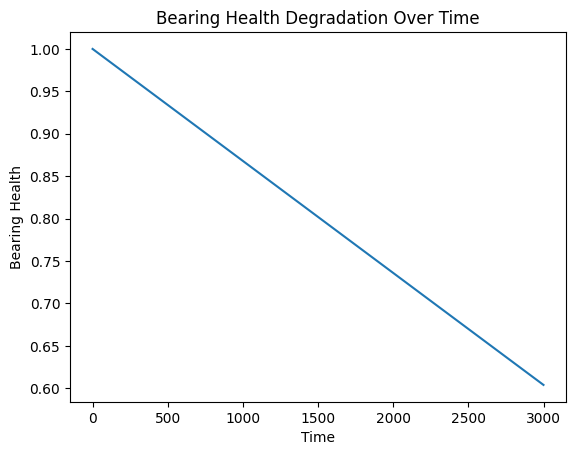

In [4]:
plt.figure()
plt.plot(df["time"], df["motor_health"])
plt.xlabel("Time")
plt.ylabel("Motor Health")
plt.title("Motor Health Degradation Over Time")
plt.show()


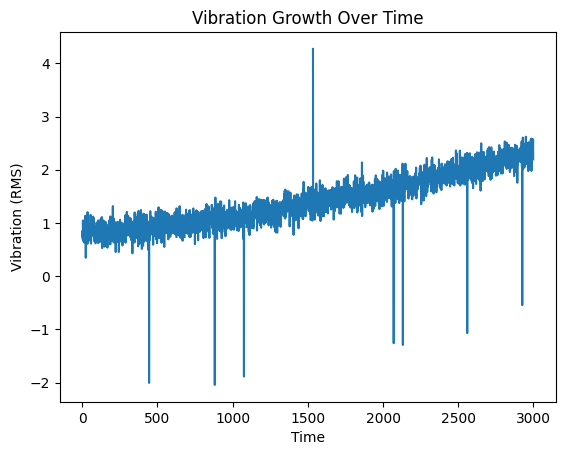

In [5]:
plt.figure()
plt.plot(df["time"], df["vibration"])
plt.xlabel("Time")
plt.ylabel("Vibration (RMS)")
plt.title("Vibration Growth Over Time")
plt.show()


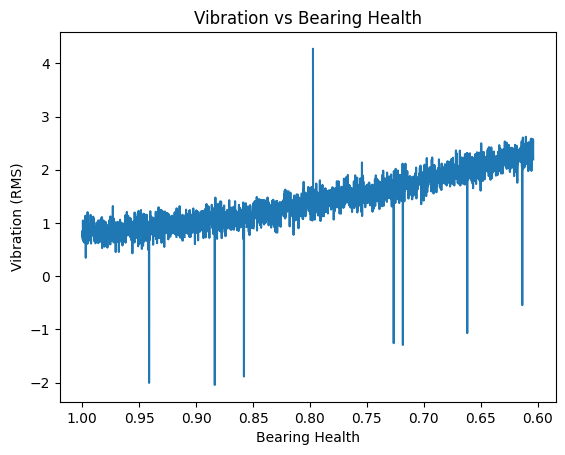

In [6]:
plt.figure()
plt.plot(df["motor_health"], df["vibration"])
plt.xlabel("Motor Health")
plt.ylabel("Vibration (RMS)")
plt.title("Vibration vs Motor Health")
plt.gca().invert_xaxis()  # optional: healthy → failed (left to right)
plt.show()


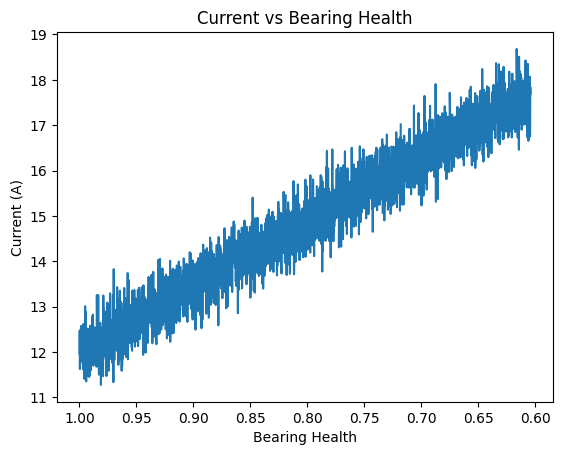

In [7]:
plt.figure()
plt.plot(df["motor_health"], df["current"])
plt.xlabel("Motor Health")
plt.ylabel("Current (A)")
plt.title("Current vs Motor Health")
plt.gca().invert_xaxis()
plt.show()


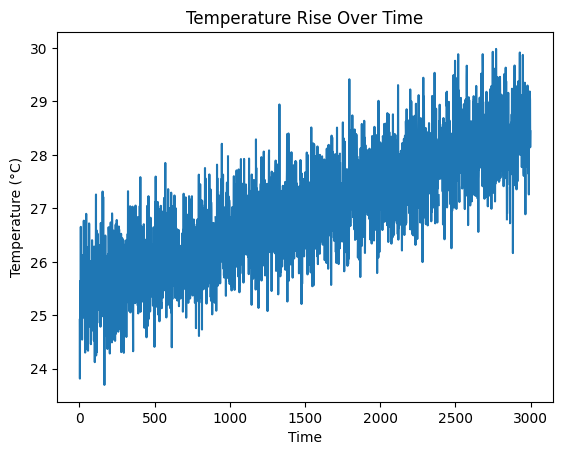

In [8]:
plt.figure()
plt.plot(df["time"], df["temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Rise Over Time")
plt.show()


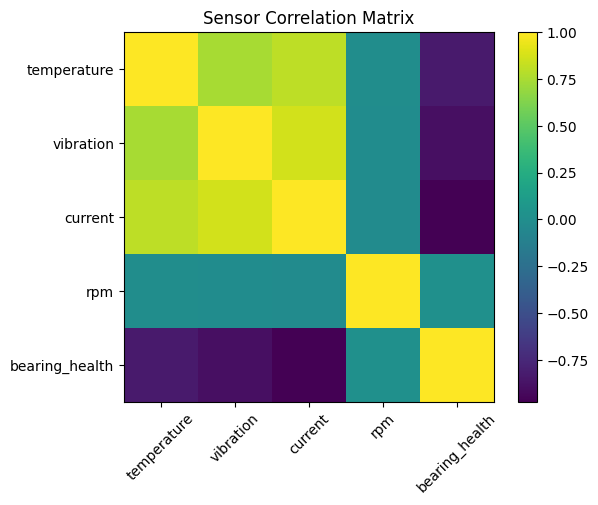

In [9]:
import numpy as np

corr = df[["temperature", "vibration", "current", "rpm", "motor_health"]].corr()

plt.figure()
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Sensor Correlation Matrix")
plt.show()


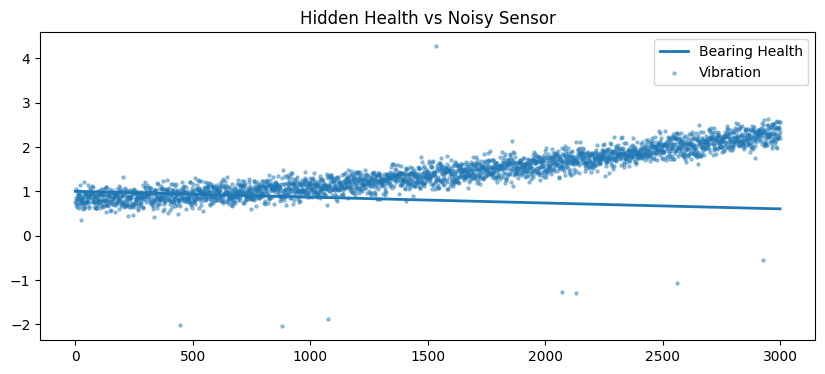

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df["time"], df["motor_health"], label="Motor Health", linewidth=2)
plt.scatter(df["time"], df["vibration"], s=5, alpha=0.4, label="Vibration")
plt.legend()
plt.title("Hidden Health vs Noisy Sensor")
plt.show()


In [11]:
import pandas as pd
from simulator.factory import FactorySimulator
from simulator.config_realistic import REALISTIC_CONFIG

factory = FactorySimulator(
    num_motors=5,
    base_config=REALISTIC_CONFIG
)

records = []

for t in range(300):
    step_records = factory.step()
    records.extend(step_records)

df = pd.DataFrame(records)
df.head()


,temperature,vibration,current,rpm,motor_health,time,motor_id
0,25.471954,0.529519,9.271991,1799.479797,0.995950,0,0
1,25.126371,0.563516,10.137852,1798.180706,0.994722,0,1
2,24.964183,0.517519,10.897759,1792.185503,0.993308,0,2
3,25.013884,0.670676,12.103184,1795.333455,0.991700,0,3
4,24.897304,0.680798,13.089611,1794.123138,0.989891,0,4


In [12]:
df.groupby("motor_id")["motor_health"].last()


motor_id
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: motor_health, dtype: float64

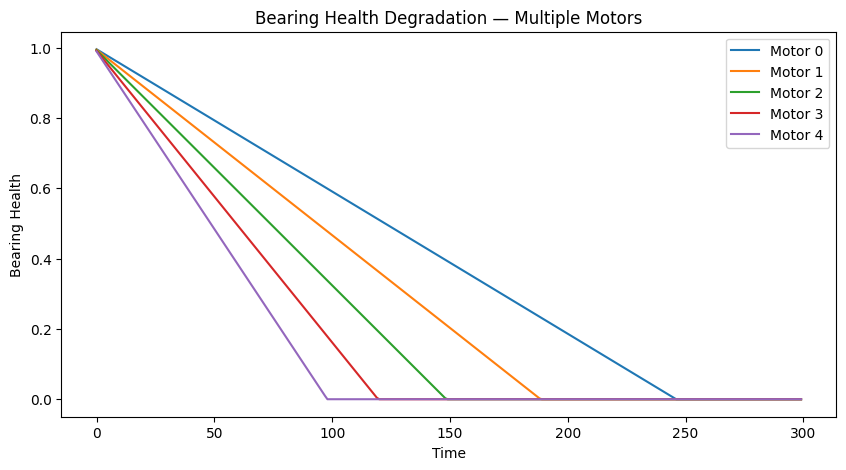

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

for motor_id in df["motor_id"].unique():
    subset = df[df["motor_id"] == motor_id]
    plt.plot(subset["time"], subset["motor_health"], label=f"Motor {motor_id}")

plt.xlabel("Time")
plt.ylabel("Motor Health")
plt.title("Motor Health Degradation — Multiple Motors")
plt.legend()
plt.show()


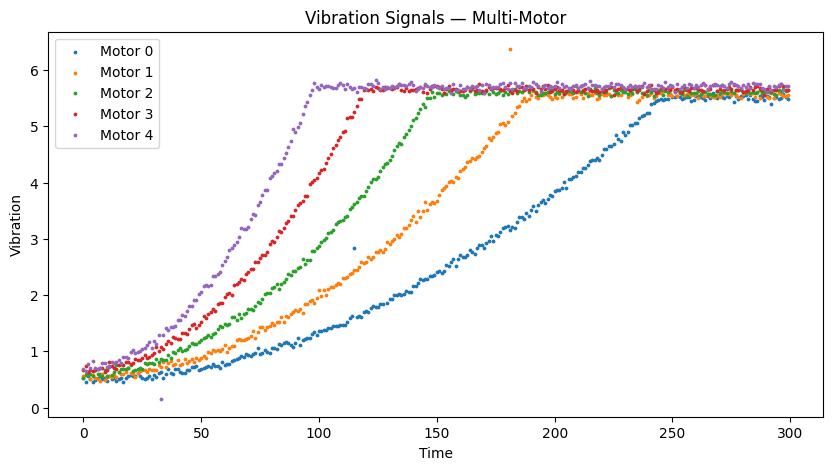

In [14]:
plt.figure(figsize=(10,5))

for motor_id in df["motor_id"].unique():
    subset = df[df["motor_id"] == motor_id]
    plt.scatter(subset["time"], subset["vibration"], s=3, label=f"Motor {motor_id}")

plt.xlabel("Time")
plt.ylabel("Vibration")
plt.title("Vibration Signals — Multi-Motor")
plt.legend()
plt.show()


In [15]:
import numpy as np
import pandas as pd

from simulator.dataset_builder import build_supervised_dataset
from simulator.splitter import split_by_motor


In [16]:
SENSOR_COLS = [
    "temperature",
    "vibration",
    "current",
    "rpm"
]


In [17]:
X, y, meta_df = build_supervised_dataset(
    df=df,
    sensor_cols=["temperature", "vibration", "current", "rpm"],
    window_size=30,
    horizon=25
)


In [18]:
X.shape
y.shape
meta_df.shape

assert X.shape[0] == y.shape[0] == meta_df.shape[0]


In [19]:
df["motor_id"].value_counts().head()


motor_id
0    300
1    300
2    300
3    300
4    300
Name: count, dtype: int64

In [20]:
splits = split_by_motor(X, y, meta_df)


In [22]:
print(len(splits["train"][2]["motor_id"].unique()))
print(len(splits["val"][2]["motor_id"].unique()))
print(len(splits["test"][2]["motor_id"].unique()))

3
1
1
